In [2]:
import os
gpu_num = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['DRJIT_LIBLLVM_PATH'] = '/home/usare/.conda/envs/sionnasim/lib/libLLVM-17.so'

In [3]:
import numpy as np
import tensorflow as tf
    
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
import matplotlib.pyplot as plt

In [4]:
scene = load_scene("./scenes/scene1.xml")

In [5]:
for i, obj in enumerate(scene.objects.values()):
    print(f"{obj.name} : {obj.radio_material.name}")
    if i >= 10:
        break

Plane : itu_concrete
map_5_osm_buildings-itu_marble : itu_marble
map_5_osm_buildings-itu_metal : itu_metal


In [6]:
scene.tx_array = PlanarArray(
                                num_rows=4,
                                num_cols=4,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="tr38901",
                                polarization="V"
                            )
scene.rx_array = PlanarArray(
                                num_rows=1,
                                num_cols=1,
                                vertical_spacing=0.5,
                                horizontal_spacing=0.5,
                                pattern="iso",
                                polarization="V"
                )


tx = Transmitter("tx", [-262, 192, 65], [0.0, 0.0, 0.0])
scene.add(tx)

rx = Receiver("rx", [-263, 166, 2], [0.0, 0.0, 0.0])
scene.add(rx)

rx2 = Receiver("rx2", [-320, 166, 2], [0.0, 0.0, 0.0])
scene.add(rx2)

In [7]:
cm = scene.coverage_map()

In [8]:
#scene.preview(coverage_map=cm)

In [9]:
paths = scene.compute_paths(diffraction=True,
                                max_depth=3)
scene.preview(paths=paths)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

Text(0, 0.5, 'a')

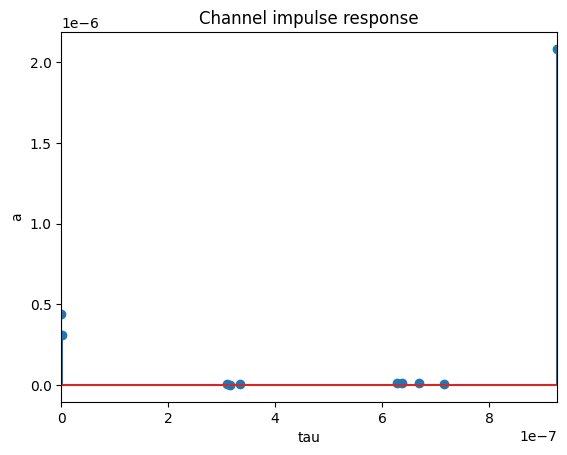

In [12]:
a, tau = paths.cir()

plt.figure()
plt.title("Channel impulse response")

t = tau[0,1,0,:]
a_bs = np.abs(a)[0,1,0,0,0,:,0]
plt.stem(t, a_bs)
plt.xlim([0, np.max(t)])
plt.xlabel("tau")
plt.ylabel("a")

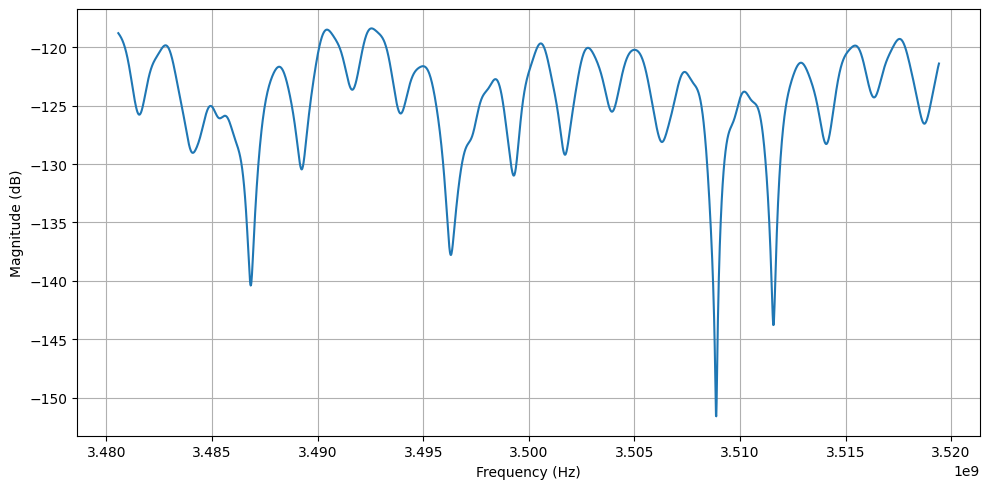

In [13]:
frequencies = subcarrier_frequencies(216*12, 15e3) 
#https://www.nrexplained.com/bandwidth
#Bandwidth of 40 MHz
#Number of subcarriers/RB = 216

h_frequency = cir_to_ofdm_channel(frequencies, a, tau)

# Transformando em db
h_frequency_db = 20*np.log10(tf.abs(h_frequency).numpy())

plt.figure(figsize=(10, 5))
plt.plot(frequencies + scene.frequency, h_frequency_db[0,0,0,0,0, 0,:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.tight_layout()
plt.grid(True)
plt.show()